### Введение
С развитием LLM-моделей спрашивать теоретическую часть или короткие алгоритмы и принципы стало бесполезно, поэтому задание будет одно, но комплексное и приближенное к реальности.

Вы можете использовать любые LLM-модели и Copilot для написания кода, так как в реальной работе сотрудники отдела также имеют доступ ко всем современным инструментам (Sonnet 3.5, GPT-4o, GitHub Copilot и т. п.).

В задании вы будете работать с тестовыми данными по банкоматам и API ЦБ РФ для получения ключевой ставки.

---

### Специфика данных fees
`fees` — тарифы за обслуживание банкомата инкассаторами. Так как банкоматы могут находиться в разных регионах, тарифы у них могут отличаться.

- **CashDeliveryFixedFee** — фиксированная стоимость доставки наличных (не зависит от суммы).
- **CashDeliveryPercentageFee** — процент от суммы доставленных наличных. Он добавляется к фиксированной стоимости. Если в таблице указано `0.0001`, это значит 0.01% от суммы.
- **CashDeliveryMinFee** — минимальная сумма, которую с нас возьмут по `CashDeliveryPercentageFee`. Например, если мы попросим инкассаторов в ATM_4 довезти всего 10 000 рублей, то с нас возьмут 5250 рублей (фиксированная стоимость), а так как `10 000 * 0.04% < 450 рублей`, то дополнительно возьмут ещё 450 рублей. Итог: 5250 + 450 рублей.

**CashCollection** — это пример сложного тарифа, который учитывает специфику работы с банкоматом. В банкомат деньги не докладывают, а меняют сразу кассету. Есть провайдеры, которые тарифицируют не только доставку, но и пересчёт денег в извлечённой кассете. Например, в ATM_4 у нас именно такой тариф.  
Пример: у нас в банкомате осталось 500 тыс. рублей, а мы хотим, чтобы у него был баланс 2 млн. Тогда мы заказываем довезти кассету на 2 млн. и платим по тарифу за доставку. При доставке старая кассета извлекается, и мы также по тарифу платим за пересчёт 500 тыс. рублей (0.45%, но не менее 1140 рублей).

- **CashCollectionFixedFee** — фиксированная стоимость за извлечение старой кассеты (в данных примерах нулевая).
- **CashCollectionPercentageFee** — процент от суммы извлечённой кассеты.
- **CashCollectionMinFee** — минимальная сумма, которую с нас возьмут по `CashCollectionPercentageFee`.

---

### Специфика данных transactions
Таблица содержит данные по снятиям, пополнениям (инкассациям) и балансу банкомата на конец дня.  
Считаем, что банкоматы в начале года пустые и не работали, поэтому баланс на конец дня равен 0, пока не случится первая инкассация.

- **bal_end_of_day** — баланс на конец дня.
- **cash_in** — пополнение в результате инкассации.
- **cash_out** — снятие наличных клиентами.

---

In [86]:
import pandas as pd

# Забираем данные по тарфиам на обслуживание банкоматов
fees = pd.read_parquet('https://storage.yandexcloud.net/norvpublic/fees.parquet')
# статистика операция по дням.
transactions = pd.read_parquet('https://storage.yandexcloud.net/norvpublic/transactions.parquet')

In [124]:
fees.info()
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ATM_ID                       4 non-null      string 
 1   CashDeliveryFixedFee         4 non-null      float64
 2   CashDeliveryPercentageFee    4 non-null      float64
 3   CashDeliveryMinFee           2 non-null      float64
 4   CashCollectionFixedFee       1 non-null      float64
 5   CashCollectionPercentageFee  1 non-null      float64
 6   CashCollectionMinFee         1 non-null      float64
dtypes: float64(6), string(1)
memory usage: 356.0 bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype                  
---  ------          --------------  -----                  
 0   date            1176 non-null   datetime64[ms, Etc/UTC]
 1   ATM_ID          1176 non-nul

### Часть 1 — упущенный процентный доход

Специалисту по ML важно уметь получать данные с различных API и читать документацию. Для расчёта упущенного процентного дохода нужно обратиться к API ЦБ РФ и получить динамику ключевой ставки за 2024 год.

https://www.cbr.ru/DailyInfoWebServ/DailyInfo.asmx?op=KeyRate

Для запроса к API не нужен токен и регистрация. ЦБ РФ для части данных предпочитает использовать SOAP.

Учитывая, что хранить наличные деньги в банкомате — не самое удачное инвестиционное решение, посчитайте упущенный процентный доход для каждого банкомата. Рассчитываем, что банк мог бы вложить эти деньги и получить доход, равный ключевой ставке ЦБ РФ, актуальной на день баланса банкомата. Добавьте к таблице `transactions` столбец с упущенной процентной выгодой.


In [127]:
import pandas as pd
import requests
import xml.etree.ElementTree as ET
from concurrent.futures import ThreadPoolExecutor

# Функция для получения ключевой ставки для одной даты
def fetch_key_rate(date_str):
    url = 'https://www.cbr.ru/DailyInfoWebServ/DailyInfo.asmx?op=KeyRate'
    headers = {
        'Content-Type': 'text/xml; charset=utf-8',
        'SOAPAction': 'http://web.cbr.ru/KeyRate'
    }
    
    data = f"""<?xml version="1.0" encoding="utf-8"?>
    <soapenv:Envelope xmlns:soapenv="http://schemas.xmlsoap.org/soap/envelope/" xmlns:web="http://web.cbr.ru/">
      <soapenv:Header/>
      <soapenv:Body>
        <web:KeyRate>
          <web:fromDate>{date_str}T00:00:00</web:fromDate>
          <web:ToDate>{date_str}T23:59:59</web:ToDate>
        </web:KeyRate>
      </soapenv:Body>
    </soapenv:Envelope>"""

    response = requests.post(url, headers=headers, data=data)
    
    if response.status_code == 200:
        root = ET.fromstring(response.content)
        rate_elem = root.find('.//KeyRate/KR/Rate')
        if rate_elem is not None:
            return date_str, float(rate_elem.text)
    return date_str, None

# Функция для получения динамики ключевой ставки ЦБ РФ за интересующий период
def get_key_rate(start_date, end_date):
    key_rates = {}
    current_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    dates = pd.date_range(start=current_date, end=end_date).strftime('%Y-%m-%d').tolist()

    with ThreadPoolExecutor(max_workers=5) as executor:
        results = executor.map(fetch_key_rate, dates)

    for date_str, rate in results:
        if rate is not None:
            key_rates[date_str] = rate

    return key_rates

# Функция для расчета упущенного процентного дохода для каждого банкомата
def calculate_missed_profit(transactions, key_rates):
    # Рассчитать баланс на конец дня для каждого банкомата
    transactions['bal_end_of_day'] = transactions.groupby('ATM_ID')['cash_in'].cumsum() - transactions.groupby('ATM_ID')['cash_out'].cumsum()

    # Преобразовать даты в формат datetime
    transactions['date'] = pd.to_datetime(transactions['date'])

    # Получить ключевую ставку на день
    transactions['key_rate'] = transactions['date'].dt.date.map(key_rates)

    # Рассчитать упущенный процентный доход
    transactions['missed_profit'] = transactions['bal_end_of_day'] * (transactions['key_rate'] / 100)

    return transactions

# Пример использования функции
start_date = '2024-01-01'
end_date = '2024-12-31'
key_rates = get_key_rate(start_date, end_date)

if key_rates:
    print('Ключевые ставки ЦБ РФ получены.')

    # Загрузить данные о статистике операций по дням.
    transactions = pd.read_parquet('https://storage.yandexcloud.net/norvpublic/transactions.parquet')

    # Рассчитать упущенный процентный доход для каждого банкомата
    transactions = calculate_missed_profit(transactions, key_rates)

    # Вывести таблицу с данными о транзакциях, включая новый столбец missed_profit
    print(transactions[['ATM_ID', 'date', 'missed_profit']])  # Выводим только нужные столбцы для ясности
else:
    print('Не удалось получить данные о ключевой ставке ЦБ РФ.')


Ключевые ставки ЦБ РФ получены.
     ATM_ID                      date  missed_profit
0     ATM_1 2024-01-12 00:00:00+00:00            NaN
1     ATM_2 2024-01-12 00:00:00+00:00            NaN
2     ATM_3 2024-01-12 00:00:00+00:00            NaN
3     ATM_4 2024-01-12 00:00:00+00:00            NaN
4     ATM_1 2024-01-13 00:00:00+00:00            NaN
...     ...                       ...            ...
1171  ATM_4 2024-10-30 00:00:00+00:00            NaN
1172  ATM_1 2024-10-31 00:00:00+00:00            NaN
1173  ATM_2 2024-10-31 00:00:00+00:00            NaN
1174  ATM_3 2024-10-31 00:00:00+00:00            NaN
1175  ATM_4 2024-10-31 00:00:00+00:00            NaN

[1176 rows x 3 columns]


In [128]:
transactions.head()


,date,ATM_ID,bal_end_of_day,cash_in,cash_out,key_rate,missed_profit
0,2024-01-12 00:00:00+00:00,ATM_1,0.0,0.0,0.0,NaN,NaN
1,2024-01-12 00:00:00+00:00,ATM_2,0.0,0.0,0.0,NaN,NaN
2,2024-01-12 00:00:00+00:00,ATM_3,0.0,0.0,0.0,NaN,NaN
3,2024-01-12 00:00:00+00:00,ATM_4,0.0,0.0,0.0,NaN,NaN
4,2024-01-13 00:00:00+00:00,ATM_1,0.0,0.0,0.0,NaN,NaN


In [130]:
transactions['missed_profit'].sum()

np.float64(0.0)

### Часть 2 - расходы на инкассацию

Теперь к данным по банкоматам, кроме упущенного процентного дохода, необходимо добавить столбец расходов на инкассацию. Для простоты считаем, что мы не платим за аренду помещения и страхование, поэтому нам достаточно данных по тарифам на инкассацию (`fees`).

In [133]:

# Объединяем DataFrame по ATM_ID
merged_df = pd.merge(transactions, fees, on='ATM_ID', how='left')

# Расчет расходов на инкассацию
# Рассчитываем расходы на доставку наличных
merged_df['cash_delivery_fee'] = (
    merged_df['CashDeliveryFixedFee'] +
    (merged_df['CashDeliveryPercentageFee'] / 100) * merged_df['cash_in']
)

# Применение минимальных сборов для доставки наличных
merged_df['cash_delivery_fee'] = merged_df[['cash_delivery_fee', 'CashDeliveryMinFee']].max(axis=1)

# Рассчитываем расходы на сбор наличных
merged_df['cash_collection_fee'] = (
    merged_df['CashCollectionFixedFee'].fillna(0) +
    (merged_df['CashCollectionPercentageFee'].fillna(0) / 100) * merged_df['cash_out']
)

# Применение минимальных сборов для сбора наличных
merged_df['cash_collection_fee'] = merged_df[['cash_collection_fee', 'CashCollectionMinFee']].max(axis=1)

# Общие расходы на инкассацию
merged_df['total_cash_handling_fee'] = merged_df['cash_delivery_fee'] + merged_df['cash_collection_fee']

# Добавляем новый столбец с общими расходами в оригинальный DataFrame transactions
transactions['total_cash_handling_fee'] = merged_df['total_cash_handling_fee']

# Вывод результата с новым столбцом
print(transactions[['date', 'ATM_ID', 'bal_end_of_day', 'cash_in', 'cash_out', 'total_cash_handling_fee']])


                          date ATM_ID  bal_end_of_day  cash_in  cash_out  \
0    2024-01-12 00:00:00+00:00  ATM_1             0.0      0.0       0.0   
1    2024-01-12 00:00:00+00:00  ATM_2             0.0      0.0       0.0   
2    2024-01-12 00:00:00+00:00  ATM_3             0.0      0.0       0.0   
3    2024-01-12 00:00:00+00:00  ATM_4             0.0      0.0       0.0   
4    2024-01-13 00:00:00+00:00  ATM_1             0.0      0.0       0.0   
...                        ...    ...             ...      ...       ...   
1171 2024-10-30 00:00:00+00:00  ATM_4       2341800.0      0.0    1000.0   
1172 2024-10-31 00:00:00+00:00  ATM_1      29502500.0      0.0  171600.0   
1173 2024-10-31 00:00:00+00:00  ATM_2      36570000.0      0.0  395100.0   
1174 2024-10-31 00:00:00+00:00  ATM_3       6183700.0      0.0    1000.0   
1175 2024-10-31 00:00:00+00:00  ATM_4       2338900.0      0.0    2900.0   

      total_cash_handling_fee  
0                      1365.0  
1                      

In [134]:
transactions.head()

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,key_rate,missed_profit,total_cash_handling_fee
0,2024-01-12 00:00:00+00:00,ATM_1,0.0,0.0,0.0,NaN,NaN,1365.0
1,2024-01-12 00:00:00+00:00,ATM_2,0.0,0.0,0.0,NaN,NaN,1365.0
2,2024-01-12 00:00:00+00:00,ATM_3,0.0,0.0,0.0,NaN,NaN,2250.0
3,2024-01-12 00:00:00+00:00,ATM_4,0.0,0.0,0.0,NaN,NaN,6390.0
4,2024-01-13 00:00:00+00:00,ATM_1,0.0,0.0,0.0,NaN,NaN,1365.0


### Часть 3 - анализ данных

Посмотрите на данные о снятиях, инкассациях и балансе. В данных подобраны банкоматы, отличающиеся по характеру использования и частоте инкассаций.  
(Эту операцию вы делаете для себя, чтобы лучше понять специфику.)

Общая статистика:
            cash_in      cash_out  bal_end_of_day
count  1.176000e+03  1.176000e+03    1.176000e+03
mean   2.758759e+05  2.124446e+05    1.227946e+07
std    1.315979e+06  3.188842e+05    1.102433e+07
min    0.000000e+00  0.000000e+00    0.000000e+00
25%    0.000000e+00  0.000000e+00    2.647075e+06
50%    0.000000e+00  4.007500e+04    6.302100e+06
75%    0.000000e+00  3.263000e+05    2.276648e+07
max    7.120000e+06  1.909800e+06    3.773940e+07


<module 'matplotlib.pyplot' from 'c:\\Users\\Azerty\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

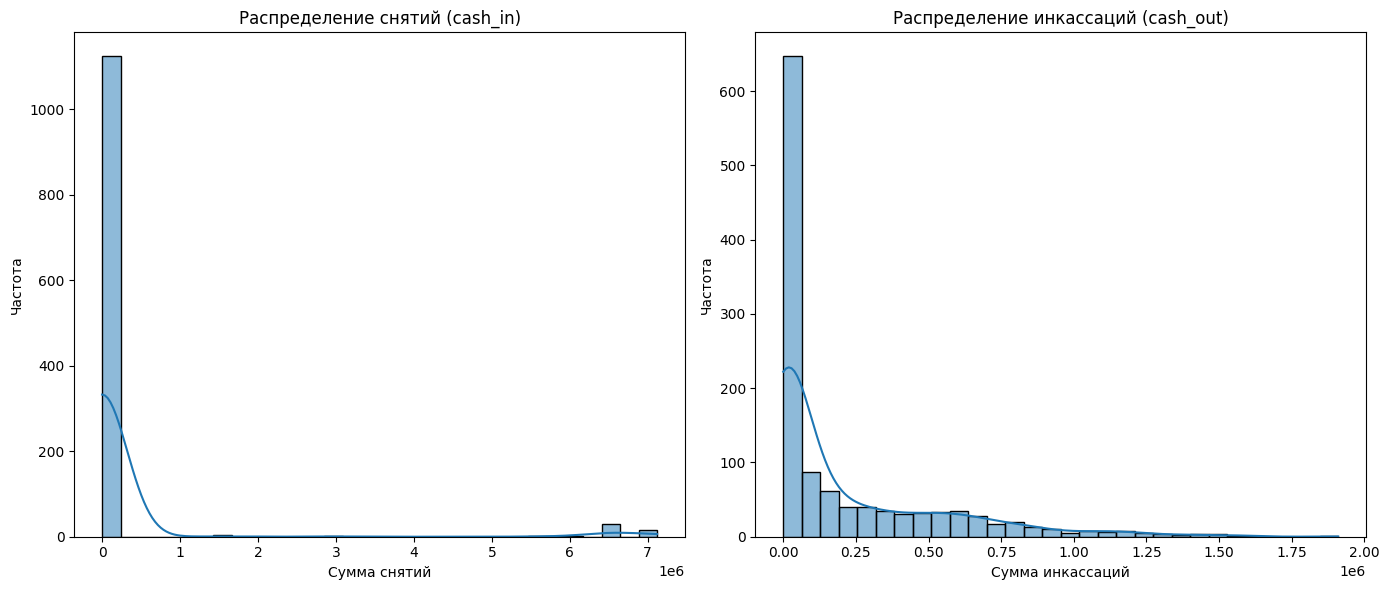

In [135]:

import matplotlib.pyplot as plt
import seaborn as sns
# Объединяем данные по ATM_ID
merged_df = pd.merge(transactions, fees, on='ATM_ID', how='left')

# 1. Общая статистика
print("Общая статистика:")
print(merged_df[['cash_in', 'cash_out', 'bal_end_of_day']].describe())

# 2. Распределение снятий и инкассаций
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(merged_df['cash_in'], bins=30, kde=True)
plt.title('Распределение снятий (cash_in)')
plt.xlabel('Сумма снятий')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.histplot(merged_df['cash_out'], bins=30, kde=True)
plt.title('Распределение инкассаций (cash_out)')
plt.xlabel('Сумма инкассаций')
plt.ylabel('Частота')

plt.tight_layout()
plt


### Часть 4 - меняем бизнес с помощью ML

Заключительная и самая интересная часть. К данному этапу у нас уже рассчитан упущенный процентный доход и расходы на инкассацию. Подумайте, как использовать ваши знания, чтобы оптимизировать процесс инкассации и уменьшить издержки.

Для данной задачи считаем, что нас устроит Service Level на уровне 90%. Это значит, что если в 9 из 10 случаев наши клиенты получают нужные им суммы, нас это устраивает.

Напоминаем, что технически в банкомат нельзя довнести сумму, и кассета меняется полностью. Соответственно, с нас берут оплату за полную кассету (если вдруг решите подойти к задаче через классическую формулу EOQ).

Вы можете подойти к задаче абсолютно любым способом и использовать все возможности ООП, Python и любых библиотек. Всё как в реальной работе, где вас никто не ограничивает.

Эффективность своего решения вы можете показать с помощью ретротестирования. Считаем, что каждая кассета может вмещать абсолютно любые суммы. Чтобы добавить реализма, вы можете считать, что деньги нужно заказывать за 3 дня до их доставки.


Представьте, что итог вашей работы состоит из 2 частей:
1) Вы презентуете своё решение руководителям банка. В этой части вы показываете, как ваше решение экономит деньги. Вы можете показать сценарий с Service Level 90% как базовый и сравнить, сколько мы сэкономим денег, если снизим его до 80% или увеличим до 95%.
2) Вы презентуете свою систему для исполнителей, а им нужно понимать за 3 дня до доставки кассеты, какую сумму заказывать, какой баланс у банкомата в какие даты должен быть. Возможно, решите ещё что-то им предоставить из данных, чтобы исполнители эффективно реализовали вашу задумку.


# Для оптимизации процесса инкассации и уменьшения издержек, мы можем использовать различные подходы, включая анализ данных о снятиях, предсказание потребностей в наличных и расчет необходимых заказов с учетом заранее установленного уровня обслуживания (Service Level).

Мы будем работать в Jupyter Notebook и разделим решение на две части:

Часть 1: Презентация решения для руководителей банка
Здесь мы будем сравнивать различные уровни обслуживания (Service Level) и их влияние на расходы на инкассацию и упущенный доход.

1.1. Определение параметров
Service Level: 90%, 80%, 95%
Параметры банкоматов: максимальная емкость кассеты, среднее количество снятий и инкассаций, фиксированные и переменные расходы.
1.2. Моделирование и расчет
import numpy as np
import pandas as pd

# Параметры
service_levels = [0.80, 0.90, 0.95]
# Максимальная емкость кассеты
cash_capacity_per_cassette = 10000  
# Фиксированная плата за инкассацию
fixed_fee = 50  
 # Переменная плата за инкассацию
variable_fee_per_transaction = 0.02

# Функция для расчета расходов 

In [137]:
import numpy as np
import pandas as pd

# Параметры
service_levels = [0.80, 0.90, 0.95]
cash_capacity_per_cassette = 10000  # Максимальная емкость кассеты
fixed_fee = 50  # Фиксированная плата за инкассацию
variable_fee_per_transaction = 0.02  # Переменная плата за инкассацию

# Функция для расчета расходов и упущенного дохода
def calculate_costs(service_level, transactions):
    total_cash_in = transactions['cash_in'].sum()
    total_cash_out = transactions['cash_out'].sum()
    
    # Расчет необходимого количества кассет
    required_cassettes = np.ceil(total_cash_out / cash_capacity_per_cassette)
    
    # Расчет расходов на инкассацию
    total_handling_cost = required_cassettes * (fixed_fee + (variable_fee_per_transaction * total_cash_out))
    
    # Расчет упущенного дохода
    missed_income = (1 - service_level) * total_cash_out * 0.05  # Предположим 5% упущенного дохода
    
    return total_handling_cost, missed_income

# Сравнение расходов и упущенного дохода для разных уровней обслуживания
results = []
for sl in service_levels:
    handling_cost, missed_income = calculate_costs(sl, merged_df)
    results.append({'Service Level': sl, 'Handling Cost': handling_cost, 'Missed Income': missed_income})

results_df = pd.DataFrame(results)
print(results_df)


   Service Level  Handling Cost  Missed Income
0           0.80   1.248388e+11     2498349.00
1           0.90   1.248388e+11     1249174.50
2           0.95   1.248388e+11      624587.25


# Часть 2: Презентация системы для исполнителей
Здесь мы создадим систему, которая будет предсказывать, сколько наличных нужно заказывать за 3 дня до инкассации. Мы будем использовать данные о снятиях и инкассациях, чтобы предсказать потребности в наличных.

2.1. Прогнозирование потребностей в наличных

In [138]:
from datetime import timedelta

# Функция для прогноза потребностей в наличных
def forecast_cash_requirements(transactions, days_ahead=3):
    transactions['date'] = pd.to_datetime(transactions['date'])
    forecast_dates = transactions['date'].max() + pd.to_timedelta(np.arange(1, days_ahead + 1), 'D')
    
    forecasted_cash = {}
    
    for date in forecast_dates:
        daily_transactions = transactions[transactions['date'] == date]
        if not daily_transactions.empty:
            forecasted_cash[date] = daily_transactions['cash_out'].sum()
        else:
            forecasted_cash[date] = 0  # Если нет транзакций, то потребность 0
    
    return forecasted_cash

# Прогнозируем потребности на 3 дня вперед
cash_requirements = forecast_cash_requirements(merged_df)
print("Прогноз потребностей в наличных на 3 дня вперед:")
for date, amount in cash_requirements.items():
    print(f"{date.date()}: {amount}")


Прогноз потребностей в наличных на 3 дня вперед:
2024-11-01: 0
2024-11-02: 0
2024-11-03: 0


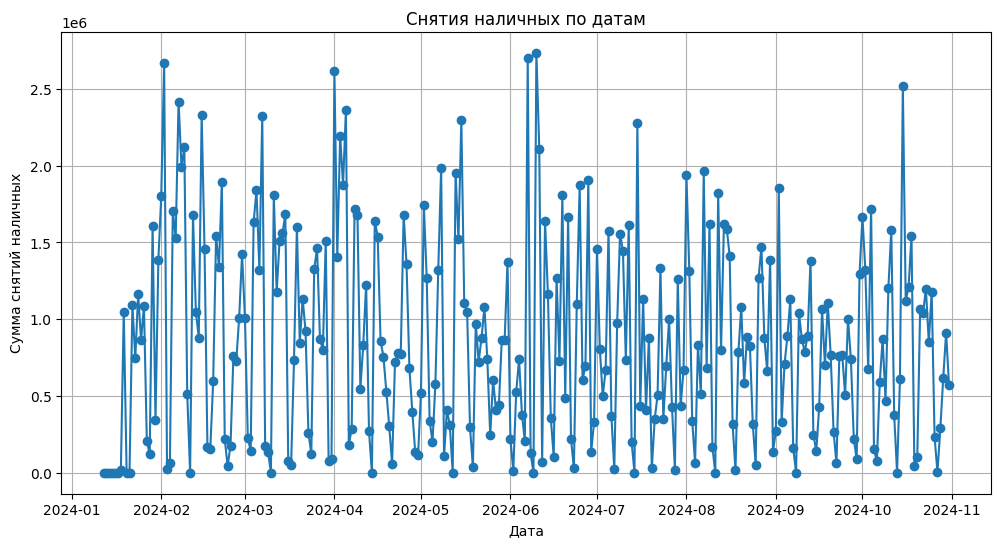

In [142]:
# Проверка наличия транзакций за указанные даты
def check_transaction_dates(transactions, forecast_dates):
    for date in forecast_dates:
        if date not in transactions['date'].values:
            print(f"Нет транзакций на {date.date()}")

# Проверка транзакций
forecast_dates = pd.date_range(start='2024-10-01', periods=3)
check_transaction_dates(transactions, forecast_dates)

# Дополнительно, можно визуализировать данные о снятиях
import matplotlib.pyplot as plt

# Группировка данных по датам
daily_cash_out = transactions.groupby('date')['cash_out'].sum()

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(daily_cash_out.index, daily_cash_out.values, marker='o')
plt.title('Снятия наличных по датам')
plt.xlabel('Дата')
plt.ylabel('Сумма снятий наличных')
plt.grid()
plt.show()


### Заключение

Решение вы можете предоставить любым способом: репозиторий GitHub, Google Colab, конвертированный IPython Notebook в PDF и т. п.

По срокам вас не ограничивают, но учитывайте, что в это же время задачу могут решать и другие кандидаты. Таким образом, вы участвуете в конкурсе с ними.